<a href="https://colab.research.google.com/github/bdunn20/book_code/blob/main/football_analytics/Ch_3_Simple_Linear_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 3 - Simple Linear Regression

---
## Rushing Yards Over Expected





###Import Packages

In [ ]:
!pip install statsmodels

In [ ]:
! pip install nfl_data_py

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 16.9 MB/s eta 0:00:00
  Created wheel for nfl_data_py: filename=nfl_data_py-0.3.1-py3-none-any.whl size=13188 sha256=3beb6d764dff97f83cee3323b944dfd4729ec62c3fb136167645bdf8304e65f1
  Stored in directory: /root/.cache/pip/wheels/ca/2e/d2/4def312ac7c070e1c0002e91ecc6923481a86c3ebd5b2c5413
Successfully built nfl_data_py


In [ ]:
import pandas as pd
import numpy as np
import nfl_data_py as nfl
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns

### EDA

In [ ]:
seasons = range(2016, 2023+1)
pbp_py = nfl.import_pbp_data(seasons)

2016 done.
2017 done.
2018 done.
2019 done.
2020 done.
2021 done.
2022 done.
2023 done.
Downcasting floats.


In [ ]:
# select running plays and remove plays w/o a rusher
pbp_py_run = pbp_py.query('play_type == "run" & rusher_id.notnull()').reset_index()
#  replace missing rushing yards w/ zero
pbp_py_run.loc[pbp_py_run.rushing_yards.isnull(), "rushing_yards"] = 0

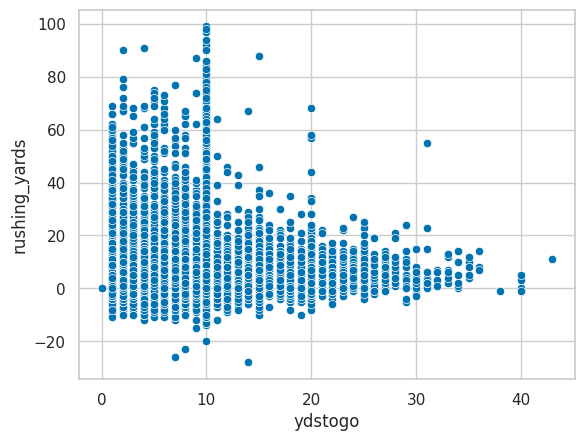

In [ ]:
# plot raw data
sns.set_theme(style="whitegrid", palette="colorblind")
sns.scatterplot(data=pbp_py_run, x="ydstogo", y="rushing_yards")
plt.show()

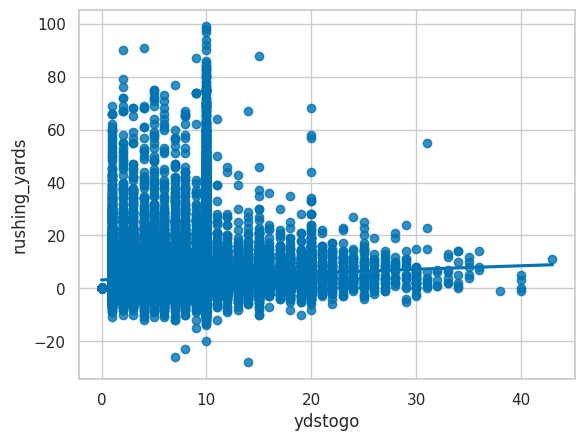

In [ ]:
# make the plot easier to read
sns.regplot(data=pbp_py_run, x="ydstogo", y="rushing_yards")
plt.show()

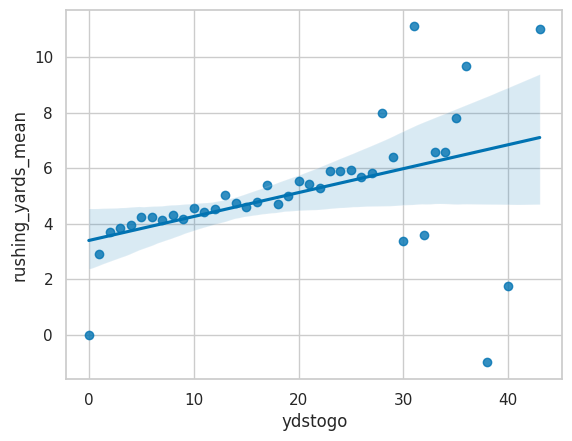

In [ ]:
# avg over each yards per carry value gained in each bin
pbp_py_run_ave = pbp_py_run.groupby(["ydstogo"]).agg({"rushing_yards": ["mean"]})

pbp_py_run_ave.columns = list(map("_".join, pbp_py_run_ave.columns))
pbp_py_run_ave.reset_index(inplace=True)

sns.regplot(data=pbp_py_run_ave, x="ydstogo", y="rushing_yards_mean")
plt.show()

### Simple Linear Model

In [ ]:
yards_to_go_py = smf.ols(formula='rushing_yards ~ 1 + ydstogo', data=pbp_py_run)

print(yards_to_go_py.fit().summary())

                            OLS Regression Results                            
Dep. Variable:          rushing_yards   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     689.7
Date:                Wed, 29 Nov 2023   Prob (F-statistic):          1.66e-151
Time:                        21:18:16   Log-Likelihood:            -3.2875e+05
No. Observations:              101022   AIC:                         6.575e+05
Df Residuals:                  101020   BIC:                         6.575e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.2039      0.045     71.150      0.0

In [ ]:
# save the residuals to create an RYOE column
# residuals are the diff b/t a model's expected (or predicted) output and the observed data
pbp_py_run["ryoe"] = yards_to_go_py.fit().resid

In [ ]:
# count of RYOE is the # of carries a rusher had
# sum of RYOE is the total RYOE
# mean of RYOE is RYOE/carry
# mean of rushing yards is the yards per carry

# flatten the columns and reset the index to make the df easier to work w/
ryoe_py = pbp_py_run.groupby(["season", "rusher_id", "rusher"]).agg({"ryoe": ["count", "sum", "mean"], "rushing_yards": "mean"})

# rename the columns to give them football-specfic names
# query the result to print only players w/ > 50 carries
ryoe_py.columns = list(map("_".join, ryoe_py.columns))
ryoe_py.reset_index(inplace=True)

ryoe_py = ryoe_py.rename(columns={
    "ryoe_count": "n",
    "ryoe_sum": "ryoe_total",
    "ryoe_mean": "ryoe_per",
    "rushing_yards_mean": "yards_per_carry"
}).query("n > 50")

print(ryoe_py.sort_values("ryoe_total", ascending=False))

      season   rusher_id     rusher    n  ryoe_total  ryoe_per  \
1989    2021  00-0036223   J.Taylor  332  421.056509  1.268242   
1440    2020  00-0032764    D.Henry  397  366.856697  0.924072   
1258    2019  00-0034796  L.Jackson  135  355.107575  2.630426   
1143    2019  00-0032764    D.Henry  387  327.903335  0.847295   
1474    2020  00-0033293    A.Jones  222  290.693201  1.309429   
...      ...         ...        ...  ...         ...       ...   
419     2017  00-0029613   D.Martin  139 -197.063400 -1.417722   
122     2016  00-0029613   D.Martin  144 -197.682325 -1.372794   
675     2018  00-0027325   L.Blount  155 -245.932813 -1.586663   
1058    2019  00-0030496     L.Bell  245 -284.577941 -1.161543   
267     2016  00-0032241   T.Gurley  278 -316.990104 -1.140252   

      yards_per_carry  
1989         5.454819  
1440         5.206549  
1258         6.800000  
1143         5.131783  
1474         5.540541  
...               ...  
419          2.920863  
122          2.

In [ ]:
# print the data sorted by RYOE per carry
print(ryoe_py.sort_values("ryoe_per", ascending=False))

      season   rusher_id        rusher    n  ryoe_total  ryoe_per  \
2235    2022  00-0034796     L.Jackson   73  276.669798  3.789997   
1258    2019  00-0034796     L.Jackson  135  355.107575  2.630426   
1286    2019  00-0035228      K.Murray   56  122.267062  2.183340   
1560    2020  00-0034796     L.Jackson  121  250.770264  2.072482   
1897    2021  00-0034750       R.Penny  119  230.430201  1.936388   
...      ...         ...           ...  ...         ...       ...   
1301    2019  00-0035342       P.Laird   61 -103.760325 -1.700989   
576     2017  00-0032940  D.Washington   57  -97.674786 -1.713593   
2022    2021  00-0036414       C.Akers   72 -138.811464 -1.927937   
67      2016  00-0027791      J.Starks   64 -129.302713 -2.020355   
1259    2019  00-0034799     K.Ballage   74 -190.289954 -2.571486   

      yards_per_carry  
2235         7.821918  
1258         6.800000  
1286         6.500000  
1560         6.264463  
1897         6.294117  
...               ...  
130

### Is RYOE a better metric?

Anytime you create a new metric, you have to test its predictive power. If the metric is not more stable than previous iterations of the evaluation, you either have to conclude the work was in vain or the underlying context actually carries the signal.

In [ ]:
# RYOE stability analysis
# keep only needed columns
cols_keep = ["season", "rusher_id", "rusher", "ryoe_per", "yards_per_carry"]

# create current df
ryoe_now_py = ryoe_py[cols_keep].copy()

# create last year df
ryoe_last_py = ryoe_py[cols_keep].copy()

# rename columns
ryoe_last_py.rename(columns = {'ryoe_per': 'ryoe_per_last',
                               'yards_per_carry': 'yards_per_carry_last'},
                                inplace=True)

# add 1 to season
ryoe_last_py["season"] += 1

# merge together
ryoe_lag_py = ryoe_now_py.merge(ryoe_last_py, how='inner', on=['rusher_id', 'rusher', 'season'])

In [ ]:
# examine the correlation for ypc
ryoe_lag_py[["yards_per_carry_last", "yards_per_carry"]].corr()

,yards_per_carry_last,yards_per_carry
yards_per_carry_last,1.000000,0.322061
yards_per_carry,0.322061,1.000000


In [ ]:
# examine correlation for RYOE
ryoe_lag_py[["ryoe_per_last", "ryoe_per"]].corr()

,ryoe_per_last,ryoe_per
ryoe_per_last,1.000000,0.342357
ryoe_per,0.342357,1.000000


So we can say that for players with more than 50 rushing attempts in back-to-back seasons, this version of RYOE per carry is slightly more stable year to year than yards per carry.

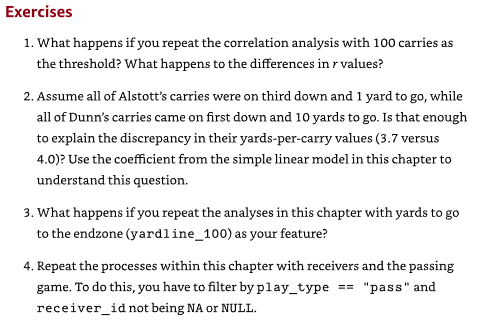